# Basic Overview
This is a continuation of the previous notebook where we explored the data in greater detail.

Comments/criticisms/appreciations are greatly accepted and appreciated. Do not be shy and send me an email at babinu@gmail.com !

Source of data : https://www.kaggle.com/c/titanic/data

In [245]:
import pandas as pd
import numpy as np

In [246]:
# Ha
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [247]:
train_data = pd.read_csv("../input/train.csv")
test_data = pd.read_csv("../input/test_data_processed_correct.csv")

In [249]:
test_data.Survived.unique()

array([0., 1.])

In [250]:
def getAlphabetClass(given_data):
    given_data['PclassAlph'] = given_data['Pclass']
    given_data['PclassAlph'].replace(to_replace=1, value='a', inplace=True)
    given_data['PclassAlph'].replace(to_replace=2, value='b', inplace=True)    
    given_data['PclassAlph'].replace(to_replace=3, value='c', inplace=True)        


In [251]:
# A direct copy from Aashita's kernel. This was her key idea !
def getGroupSize(df):
    Ticket_counts = df.Ticket.value_counts()
    df['Ticket_counts'] = df.Ticket.apply(lambda x: Ticket_counts[x])
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    df['GroupSize'] = df[['Family_size', 'Ticket_counts']].max(axis=1)
    return df

In [252]:
# Gets classes as alphabets which makes it easier to be interpreted as  categorical predictors later on.
getAlphabetClass(train_data)
getAlphabetClass(test_data)

In [253]:
getGroupSize(train_data)
getGroupSize(test_data)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,PclassAlph,Ticket_counts,Family_size,GroupSize
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0,c,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0,c,1,2,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0,b,1,1,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0,c,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0,c,1,3,3
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,1.0,c,1,1,1
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,0.0,c,1,1,1
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,1.0,b,1,3,3
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1.0,c,1,1,1
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S,0.0,c,1,3,3


In [254]:
# Add a column called Predictions in training data, which will become handy while doing
# cross validation.
train_data['Predictions'] = -1

In [255]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PclassAlph,Ticket_counts,Family_size,GroupSize,Predictions
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,c,1,2,2,-1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,a,1,2,2,-1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,c,1,1,1,-1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,a,2,2,2,-1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,c,1,1,1,-1


In [256]:
from sklearn.preprocessing import Imputer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [257]:
def get_train_test_data(train_data,
                        X_columns=['Sex', 'PclassAlph', 'Age'], 
                        Y_columns=['Survived']):
    # Simple training and testing
    X = train_data[X_columns]
    Y = train_data[Y_columns]

    X_one_hot = pd.get_dummies(X)

    # Do imputation on relevant columns.
    X_train, X_test, Y_train, Y_test = train_test_split(X_one_hot, Y, random_state=0)

    return (X_train, X_test, Y_train, Y_test, X_one_hot, Y)


In [258]:
def create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test, n_estimators=100, 
                                            learning_rate=0.1):
    # Rewrite everything as a pipeline
    my_pipeline = make_pipeline(Imputer(), 
                                XGBClassifier(seed=1, n_estimators=n_estimators, learning_rate=learning_rate))
    my_pipeline.fit(X_train, Y_train.values.ravel())
    predictions = my_pipeline.predict(X_test)
    out_of_sample_score = 1.0 - mean_absolute_error(predictions, Y_test)
    return (my_pipeline, out_of_sample_score, predictions)

In [259]:
def cross_validate(my_pipeline, X_one_hot, Y):
    cross_val_scores = cross_val_score(my_pipeline, X_one_hot, Y, scoring='neg_mean_absolute_error', cv=5)
    return 1.0  + cross_val_scores.mean()

In [260]:
def train_test_cross_validate(train_data, 
                              X_columns=['Sex', 'PclassAlph', 'Age'], 
                              Y_columns=['Survived']):
    (X_train, X_test, Y_train, Y_test, X_one_hot, Y) = get_train_test_data(train_data, X_columns, Y_columns)
    my_pipeline, out_of_sample_score, predictions_test = \
        create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)

    print("Number of entries in training set is {0}".format(len(X_train)))
    predictions_train = my_pipeline.predict(X_train)
    num_correct_predictions_train = int((1.0 - mean_absolute_error(predictions_train, Y_train)) * len(Y_train))


    print("Number of correct predictions in training set is {0}".format(num_correct_predictions_train))    
    print("Number of entries in test set is {0}".format(len(X_test)))    
    print("Number of correct predictions in test set is {0}".format(int(out_of_sample_score * len(X_test))))

    cross_validation_score = cross_validate(make_pipeline(Imputer(), XGBClassifier(seed=1)), X_one_hot, Y.values.ravel())
    return (my_pipeline, out_of_sample_score, cross_validation_score)

In [261]:
# Make sure that unnecessary deprecation warnings are avoided.
# Thanks to https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


### Correlation between predictors. 

In [262]:
train_data[['Survived', 'Pclass', 'Age', 'SibSp', 
             'Parch', 'Fare', 'Ticket_counts', 'Family_size', 'GroupSize']].corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Ticket_counts,Family_size,GroupSize
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.038247,0.016639,0.061099
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.002633,0.065997,0.018783
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.253507,-0.301914,-0.281838
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.661622,0.890712,0.809574
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.593076,0.783111,0.701479
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.345541,0.217138,0.334278
Ticket_counts,0.038247,-0.002633,-0.253507,0.661622,0.593076,0.345541,1.000000,0.748487,0.911826
Family_size,0.016639,0.065997,-0.301914,0.890712,0.783111,0.217138,0.748487,1.000000,0.903764
GroupSize,0.061099,0.018783,-0.281838,0.809574,0.701479,0.334278,0.911826,0.903764,1.000000


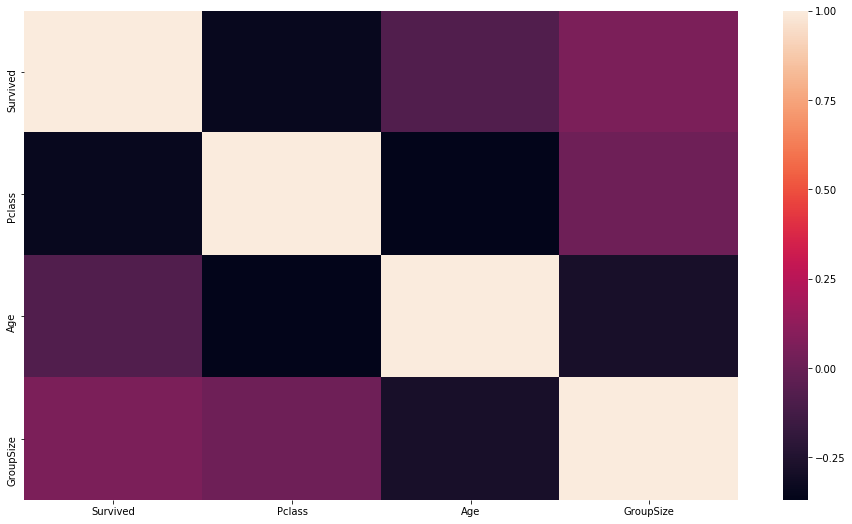

In [263]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.heatmap(train_data[['Survived', 'Pclass', 'Age', 'GroupSize']].corr(), ax=ax)

The correlation level looks acceptable here.

### Model 1: Sex as the only predictor

In [264]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex'], 
                              ['Survived'])
    
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7867150249291879


### Model 2: Sex and Pclass as predictors.

In [265]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 527
Number of entries in test set is 223
Number of correct predictions in test set is 174
Out of sample score is 0.7802690582959642
Cross val score is 0.7733072037001376


### Model 3: Sex, Pclass and Age as predictors

In [266]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 565
Number of entries in test set is 223
Number of correct predictions in test set is 184
Out of sample score is 0.8251121076233183
Cross val score is 0.8047557492817721


### Model 4 : Use Sex, Age, Pclass, GroupSize

In [267]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age', 'GroupSize'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 572
Number of entries in test set is 223
Number of correct predictions in test set is 185
Out of sample score is 0.8295964125560538
Cross val score is 0.8227022466590561


### Model 5 : Use Sex, Age, Pclass, GroupSize, Parch

In [268]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age', 'GroupSize', 'Parch'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 569
Number of entries in test set is 223
Number of correct predictions in test set is 185
Out of sample score is 0.8295964125560538
Cross val score is 0.8226896215919854


### Model 6 : Use Sex, Age, Pclass, GroupSize, Parch,SibSp

In [269]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age', 'GroupSize', 'Parch', 'SibSp'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 569
Number of entries in test set is 223
Number of correct predictions in test set is 185
Out of sample score is 0.8295964125560538
Cross val score is 0.8227022466590561


### Model 7 : Use Sex, Age, Pclass, GroupSize, FarePerPerson


In [270]:
train_data['FarePerPerson'] = train_data['Fare']/train_data['GroupSize']
test_data['FarePerPerson'] = test_data['Fare']/test_data['GroupSize']

In [271]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age', 'GroupSize','Fare'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 579
Number of entries in test set is 223
Number of correct predictions in test set is 189
Out of sample score is 0.8475336322869955
Cross val score is 0.8294248466284865


### Model 8 : Use Sex, Age, Pclass, GroupSize, Fare


In [272]:
(my_pipeline, out_of_sample_score, cross_validation_score) = \
    train_test_cross_validate(train_data,
                              ['Sex', 'PclassAlph', 'Age', 'GroupSize','Fare'], 
                              ['Survived'])
print("Out of sample score is {0}\nCross val score is {1}".format(out_of_sample_score, cross_validation_score))



Number of entries in training set is 668
Number of correct predictions in training set is 579
Number of entries in test set is 223
Number of correct predictions in test set is 189
Out of sample score is 0.8475336322869955
Cross val score is 0.8294248466284865


### Conclusion
With our emphasis on parsimonious models and cross validation score, we will go for model 8 (NOTE : We removed the predictors Parch and SibSp in between , since they were not adding any value (that information is broadly obtained in the group size variable itself).

NOTE : The questions that remain are the following ?
1. Why didn't the fare per reason variable not work ?
2. How on earth would we have come up with the group size variable ?

### Let us try to optimize the chosen model using cross validation

In [273]:
X_train, X_test, Y_train, Y_test,X_one_hot, Y = get_train_test_data(
     train_data, 
     X_columns=['Sex', 'PclassAlph', 'Age', 'GroupSize','Fare'],
     Y_columns=['Survived'])


my_imputer = Imputer()

X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)



In [274]:
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
params = {"Objective" : 'gbtree',
          "eval_metric" : 'error',
          'learning_rate' : 0.05
         }
cv = xgb.cv(dtrain=dtrain, params=params, num_boost_round=100, nfold=5, seed=0, early_stopping_rounds=10)

In [275]:
cv.tail(1)

,test-error-mean,test-error-std,train-error-mean,train-error-std
22,0.166143,0.0095,0.099176,0.008444


### Conclusion.

Let us generate predictions on out of sample data and submit a file to kaggle using model 5.

In [276]:
#create_pipeline_and_out_of_sample_score(X_train, X_test, Y_train, Y_test)
X_columns = ['Sex', 'PclassAlph', 'Age', 'GroupSize','Fare']
Y_column = ['Survived']
X_train = train_data[X_columns]
X_train_one_hot = pd.get_dummies(X_train)
Y_train = train_data[Y_column]
X_test = test_data[X_columns]
X_test_one_hot = pd.get_dummies(X_test)
Y_test = test_data[Y_column]
(my_pipeline, out_of_sample_score, predictions_out_of_sample) = \
    create_pipeline_and_out_of_sample_score(X_train_one_hot, 
                                            X_test_one_hot,
                                            Y_train,
                                            Y_test,
                                            22,
                                            0.05)
print("Complete score on out of sample data is {0}".format(out_of_sample_score))
test_data['Predictions'] = predictions_out_of_sample
kaggle_data = test_data[['PassengerId', 'Predictions']].copy()
kaggle_data.rename(columns={'Predictions' : 'Survived'}, inplace=True)
kaggle_data.sort_values(by=['PassengerId']).to_csv('kaggle_out_xgboost_aashita_idea.csv', index=False)

Complete score on out of sample data is 0.7870813397129186


### Visualizing the model.
The task is not done yet ! We need to be able to see how exactly the model makes it's predictions and see if they make sense !!!

Many of visualizations do not support pipelines. Hence, we do a manual imputation on the data and train models using the same to replicate the model that was built using pipelines.

In [277]:
X_train_one_hot_new = X_train_one_hot.copy()
X_train_one_hot_new.loc[X_train_one_hot_new['Age'].isnull(), 'Age'] = X_train_one_hot['Age'].mean()
my_model = XGBClassifier(n_estimators=22, learning_rate=0.05)
my_model.fit(X_train_one_hot_new, Y_train.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=22,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### Using plot_tree

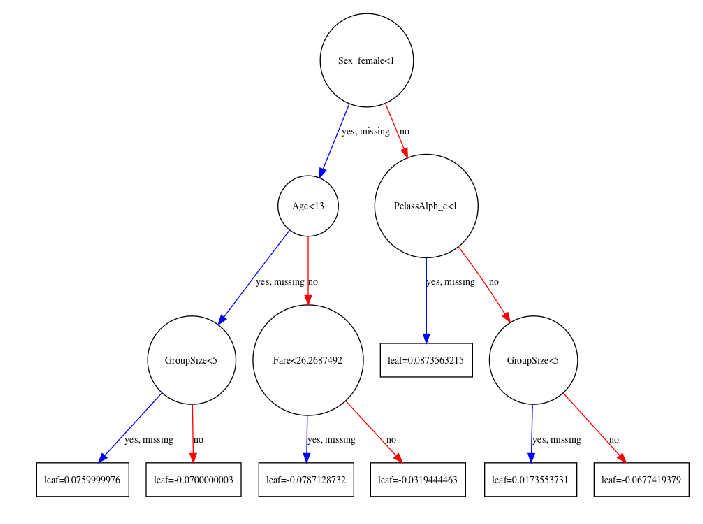

In [278]:
from xgboost import plot_tree
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plot_tree(my_model, ax=ax)


It is not very clear, so let us go for graphviz, which has a much better display.

#### Using graphviz
We use graphviz , a package that works nicely with displaying xgboost models. Unfortunately, it does not directly work with pipeline 

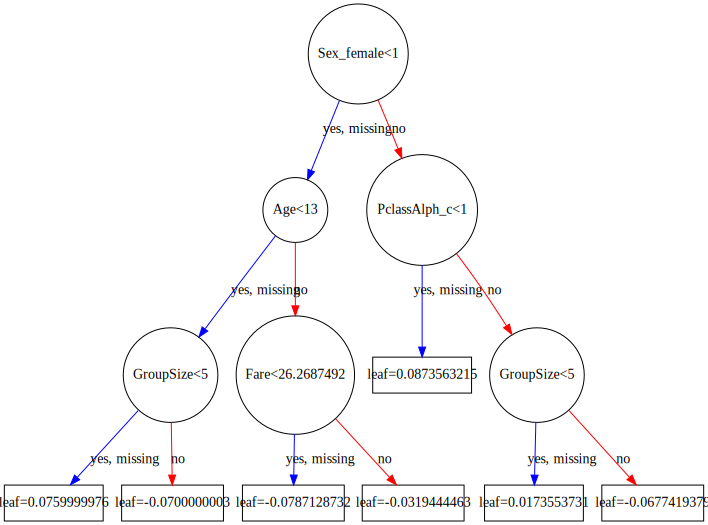

In [279]:

xgb.to_graphviz(my_model)

Thus, we can see Age tends to play a mucb more prominent role for males whereas pclass looks to be playing a bigger role for females.

Let us see the importance of each of these variables here.

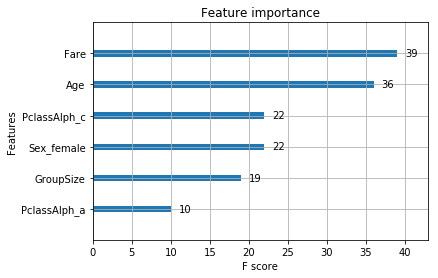

In [280]:
xgb.plot_importance(my_model)

This comes as a suprise since fare is given a much higher score than what we would have expected. In fact, on further analysis it looks like this plot is really susceptible to the number of estimators fed to the model and hence is doubtful.

As shown below, the importance plot changes significantly when the number of estimators is changed to 14, whereas other plots do not show any change at all.

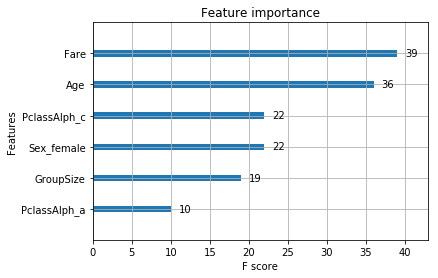

In [281]:
my_model2 = XGBClassifier(n_estimators=22, learning_rate=0.05)
my_model2.fit(X_train_one_hot_new, Y_train.values.ravel())
xgb.plot_importance(my_model2)

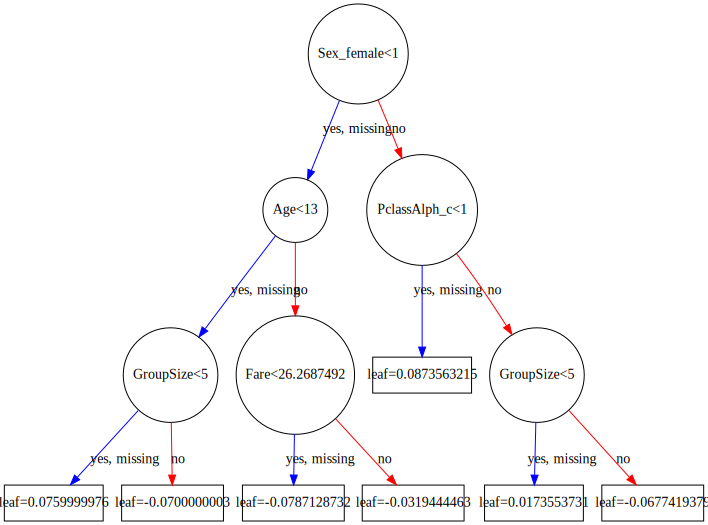

In [282]:
xgb.to_graphviz(my_model2)

Thus, we ignore the result of the importance plot for now.

### Use partial dependence plots.
Partial dependence plots are very useful for us to see the relative importance of variables. Unfortunately, they are not available for the xgboost version boosting trees, but only for sklearn version of the same.

In [283]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators=22, learning_rate=0.05)
gbcl.fit(X_train_one_hot_new, Y_train.values.ravel())
 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=22,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [284]:
X_train_one_hot_new.columns

Index(['Age', 'GroupSize', 'Fare', 'Sex_female', 'Sex_male', 'PclassAlph_a',
       'PclassAlph_b', 'PclassAlph_c'],
      dtype='object')

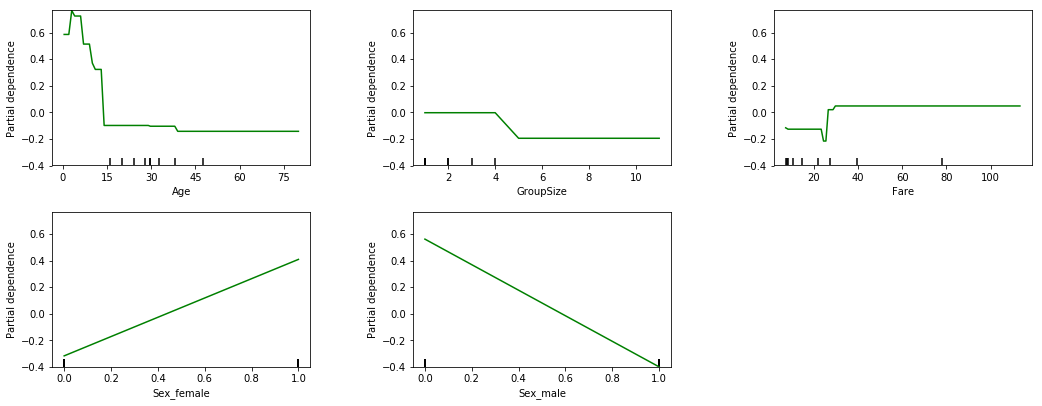

In [285]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
my_plots = plot_partial_dependence(gbcl, 
                                   features=[0, 1, 2, 3, 4], 
                                   X=X_train_one_hot_new, 
                                   feature_names=['Age', 
                                                  'GroupSize', 
                                                  'Fare',
                                                  'Sex_female',
                                                  'Sex_male'],
                                  ax=ax)

Comments :
1. Age :  As expected , age is much more influential when it is small.
2. Fare : Looks to be having an effect when it is big.
3. Sex : As expected , the influence is increasing for females.
